In [1]:
%pylab inline

import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate
import time

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Modules for generating waveforms
import lalsimulation # Get waveform functions
import lal # Get constants
import pycbc.types # TimeSeries
import pycbc.waveform # Waveforms

In [3]:
lal.G_SI, lal.C_SI, 1.0e6*lal.PC_SI, lal.MSUN_SI

(6.67384e-11, 299792458.0, 3.085677581491367e+22, 1.9885469549614615e+30)

In [4]:
# Use the exact same units as LAL
G_SI = 6.67384e-11
C_SI = 299792458.0
MPC_SI = 3.085677581491367e+22
MSUN_SI = 1.9885469549614615e+30

In [5]:
# Versions of HDF5 earlier than 1.8.13 seem to give trouble
import h5py
print h5py.version.info

Summary of the h5py configuration
---------------------------------

h5py    2.5.0
HDF5    1.8.14
Python  2.7.10 (default, Sep 24 2015, 00:07:46) 
[GCC 4.4.5 20110214 (Red Hat 4.4.5-6)]
sys.platform    linux2
sys.maxsize     9223372036854775807
numpy   1.10.1



In [29]:
sys.path.insert(0, '../cbcrom')

import timedomainwaveform as tdwave
import timedomainrom as tdrom
import eobtrainingset as eob
import greedy
import empiricalinterpolation as eim
import diagnostics as diagnostics
import chebyshev as cheb
import timeseriesutils as tsutils

import imp
imp.reload(tdwave)
imp.reload(tdrom)
imp.reload(eob)
imp.reload(greedy)
imp.reload(eim)
imp.reload(diagnostics)
imp.reload(cheb)
imp.reload(tsutils)

<module 'timeseriesutils' from '../cbcrom/timeseriesutils.pyc'>

In [30]:
pyplot.rcParams.update({
    'figure.figsize': (8, 6),    # figure size in inches
    'text.usetex': True,
#     "font.family": 'serif',
#     "font.serif": ['Computer Modern'],
    'font.size': 14,
    #'axes.titlesize': 20,
    'axes.labelsize': 20,
    'axes.linewidth': 2,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20,
    'legend.fontsize': 14,
    'xtick.major.size': 8,
    'xtick.minor.size': 4, 
    'xtick.major.width': 2,
    'xtick.minor.width': 2,
    'xtick.direction': 'out',
    'ytick.major.size': 8,
    'ytick.minor.size': 4, 
    'ytick.major.width': 2,
    'ytick.minor.width': 2,
    'ytick.direction': 'out',  
    'axes.prop_cycle'    : cycler('color', 'bgrcmyk'),
    })

# Load ROM

In [31]:
memb_size=2**26-1

# Bamp_filename = '../data/Bamp_cheb_3_%d.hdf5'
# Bphase_filename = '../data/Bphase_cheb_3_%d.hdf5'
# ampcoeff_filename = '../data/amp_coeffs_cheb_3.hdf5'
# phasecoeff_filename = '../data/phase_coeffs_cheb_3.hdf5'

# Bamp_filename = '../data/Bamp_cheb_9_%d.hdf5'
# Bphase_filename = '../data/Bphase_cheb_9_%d.hdf5'
# ampcoeff_filename = '../data/amp_coeffs_cheb_9.hdf5'
# phasecoeff_filename = '../data/phase_coeffs_cheb_9.hdf5'

Bamp_filename = '../data/Bamp_cheb_16_%d.hdf5'
Bphase_filename = '../data/Bphase_cheb_16_%d.hdf5'
ampcoeff_filename = '../data/amp_coeffs_cheb_16.hdf5'
phasecoeff_filename = '../data/phase_coeffs_cheb_16.hdf5'

rom = tdrom.load_reduced_order_model_time_domain_waveform(Bamp_filename, Bphase_filename, memb_size,
                                                  ampcoeff_filename, phasecoeff_filename)

In [32]:
def reduced_order_model_time_series(rom, **kwargs):
    """Convert to pycbc TimeSeries.
    """
    tstart, delta_t, hp, hc = rom.evaluate_physical_units(**kwargs)
    hplus = pycbc.types.TimeSeries(hp, epoch=tstart, delta_t=delta_t)
    hcross = pycbc.types.TimeSeries(hc, epoch=tstart, delta_t=delta_t)
    return hplus, hcross

In [33]:
phiRef=0.0
deltaT=1./2**14
fLow=50.0
fRef=50.0
distance=100.0e6*lal.PC_SI
inclination=0.0
m1SI=1.35*lal.MSUN_SI
m2SI=1.35*lal.MSUN_SI
lambda1=2000.0
lambda2=2000.0
hp1, hc1 = lalsimulation.SimInspiralTEOBResumROM(phiRef,deltaT,fLow,fRef,distance,inclination,m1SI,m2SI,lambda1,lambda2)
hp2, hc2 = lalsimulation.SimInspiralTEOBResumROM(phiRef,deltaT,fLow,fRef,distance,inclination,m1SI,m2SI,lambda1,lambda2)

In [12]:
len(hp1.data.data), len(hc1.data.data)

(243546, 243546)

In [13]:
hp1.data.data, hc1.data.data

(array([  2.06040957e-23,   2.06003287e-23,   2.05889878e-23, ...,
         -1.32712956e-22,  -1.61325009e-22,  -1.54185824e-22]),
 array([  0.00000000e+00,   3.95055078e-25,   7.89966312e-25, ...,
          9.40921820e-23,   2.67943739e-23,  -4.90612054e-23]))

In [14]:
pycbc.waveform.td_approximants()

['TaylorEt',
 'IMRPhenomA',
 'IMRPhenomC',
 'IMRPhenomB',
 'EOBNRv2',
 'PhenSpinTaylor',
 'PhenSpinTaylorRD',
 'NR_hdf5',
 'TEOBResum_ROM',
 'EOBNRv2HM',
 'SpinTaylorT4',
 'TaylorT1',
 'TaylorT3',
 'TaylorT2',
 'HGimri',
 'TaylorT4',
 'IMRPhenomD',
 'IMRPhenomPv2',
 'SEOBNRv1',
 'SpinDominatedWf',
 'SEOBNRv3',
 'SEOBNRv2',
 'SpinTaylorT1',
 'SpinTaylorT2',
 'EccentricTD',
 'SEOBNRv2_opt']

In [16]:
approximant = 'TEOBResum_ROM'
f_sample = 2**14
f_lower = 50.0

delta_t = 1.0/f_sample
distance, inclination = 100.0, 0.0
mass1, mass2 = 1.4, 1.4

lambda1, lambda2 = 1000.0, 1000.0
    
pycbc.waveform.get_td_waveform(approximant=approximant,
            mass1=mass1, mass2=mass2, 
            distance=distance, inclination=inclination,
            delta_t=delta_t, f_lower=f_lower)

RuntimeError: Internal function call failed: Memory allocation error

# Compare timing of ROM to TaylorT4

## Function for timing

In [15]:
# def calculate_time(f_lower, f_sample, approximant):
#     """
#     """
    
#     #######
#     phiRef=0.0
#     #######
    
#     distance, inclination = 100.0, 0.0
#     mass1, mass2, lambda1, lambda2 = 1.35, 1.35, 4000.0, 4000.0
    
#     delta_t = 1.0/f_sample
    
#     if approximant=='rom':
#         t0 = time.clock()
#         reduced_order_model_time_series(rom, 
#             mass1=mass1, mass2=mass2, lambda1=lambda1, lambda2=lambda2, 
#             delta_t=delta_t, f_lower=f_lower, f_ref=None, 
#             distance=distance, inclination=inclination, coa_phase=None)
#         t1 = time.clock()
#     elif approximant=='TEOBResum_ROM':
#         t0 = time.clock()
#         phiRef=0.0
#         fLow = f_lower
#         fRef = f_lower
#         #fLow=50.0
#         #fRef=50.0
#         distance=100.0e6*lal.PC_SI
#         inclination=0.0
#         m1SI=mass1*lal.MSUN_SI
#         m2SI=mass2*lal.MSUN_SI
#         lalsimulation.SimInspiralTEOBResumROM(phiRef,delta_t,fLow,fRef,distance,inclination,m1SI,m2SI,lambda1,lambda2)
#         t1 = time.clock()
#     else:
#         t0 = time.clock()
#         pycbc.waveform.get_td_waveform(approximant=approximant,
#             mass1=mass1, mass2=mass2, 
#             distance=distance, inclination=inclination,
#             delta_t=delta_t, f_lower=f_lower)
#         t1 = time.clock()
    
#     return t1-t0

In [34]:
def calculate_time(f_lower, f_sample, approximant, neval=5):
    """
    """
    
    #######
    phiRef=0.0
    #######
    
    distance, inclination = 100.0, 0.0
    mass1, mass2, lambda1, lambda2 = 1.4, 1.4, 4000.0, 4000.0
    
    delta_t = 1.0/f_sample
    
    times = np.zeros(neval+1)
    times[0] = time.clock()
    for n in range(neval):
        if approximant=='rom':
            reduced_order_model_time_series(rom, 
                mass1=mass1, mass2=mass2, lambda1=lambda1, lambda2=lambda2, 
                delta_t=delta_t, f_lower=f_lower, f_ref=None, 
                distance=distance, inclination=inclination, coa_phase=None)
        elif approximant=='TEOBResum_ROM':
            phiRef=0.0
            fLow = f_lower
            fRef = f_lower
            #fLow=50.0
            #fRef=50.0
            distance=100.0e6*lal.PC_SI
            inclination=0.0
            m1SI=mass1*lal.MSUN_SI
            m2SI=mass2*lal.MSUN_SI
            lalsimulation.SimInspiralTEOBResumROM(phiRef,delta_t,fLow,fRef,distance,inclination,m1SI,m2SI,lambda1,lambda2)
        else:
            pycbc.waveform.get_td_waveform(approximant=approximant,
                mass1=mass1, mass2=mass2, 
                distance=distance, inclination=inclination,
                delta_t=delta_t, f_lower=f_lower)
        times[n+1] = time.clock()
    
    dts = times[1:]-times[:-1]
    #return dts, (times[-1]-times[0])/neval, np.sum(dts)/neval, np.std(dts)
    return (times[-1]-times[0])/neval, np.std(dts)

## Do the timing tests

In [44]:
# fl = 10
# fh = 100
# df = 5
# f_lowers = np.arange(fl, fh, df)
f_lowers = np.array([10, 11, 12, 14, 16, 18, 20, 30, 40, 50, 60, 70, 80, 90, 100])

neval = 16

f_sample = 2**12
ROMpy4k = np.array([calculate_time(f_lower, f_sample, 'rom', neval=neval) for f_lower in f_lowers])
ROMlal4k = np.array([calculate_time(f_lower, f_sample, 'TEOBResum_ROM', neval=neval) for f_lower in f_lowers])

f_sample = 2**14
ROMpy16k = np.array([calculate_time(f_lower, f_sample, 'rom', neval=neval) for f_lower in f_lowers])
ROMlal16k = np.array([calculate_time(f_lower, f_sample, 'TEOBResum_ROM', neval=neval) for f_lower in f_lowers])

In [47]:
f_lowers, ROMlal4k

(array([ 10,  11,  12,  14,  16,  18,  20,  30,  40,  50,  60,  70,  80,
         90, 100]), array([[ 0.784375  ,  0.04182833],
        [ 0.598125  ,  0.06247187],
        [ 0.4875    ,  0.06139015],
        [ 0.3175    ,  0.04656984],
        [ 0.21875   ,  0.02666341],
        [ 0.165625  ,  0.00496078],
        [ 0.1375    ,  0.00829156],
        [ 0.074375  ,  0.00496078],
        [ 0.055625  ,  0.00609175],
        [ 0.049375  ,  0.00555512],
        [ 0.044375  ,  0.00609175],
        [ 0.043125  ,  0.00582961],
        [ 0.0425    ,  0.00559017],
        [ 0.04125   ,  0.00599479],
        [ 0.041875  ,  0.00634306]]))

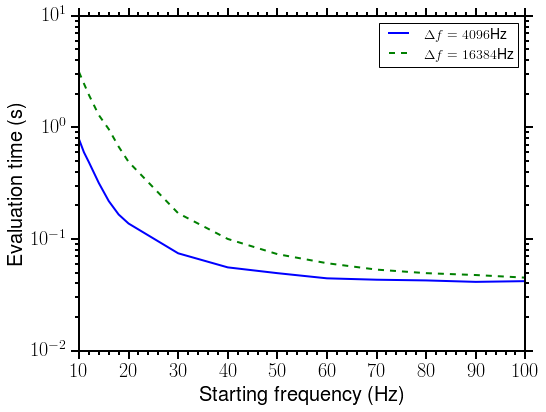

In [45]:
fig = plt.figure(figsize=(8, 6))
axes = fig.add_subplot(111)

axes.plot(f_lowers, ROMlal4k[:, 0], lw=2, label=r'$\Delta f = 4096$Hz')
axes.plot(f_lowers, ROMlal16k[:, 0], lw=2, ls='--', label=r'$\Delta f = 16384$Hz')


axes.set_yscale('log')
axes.set_xlim([10, 100.0])
#axes.set_ylim([0.03, 10.0])
axes.minorticks_on()
axes.set_xlabel(r'Starting frequency (Hz)')
axes.set_ylabel(r'Evaluation time (s)')
axes.legend(loc='upper right')

In [48]:
fig.savefig('/home/bdlackey/public_html/ROM/timing.pdf', format='pdf', transparent=True, bbox_inches='tight')

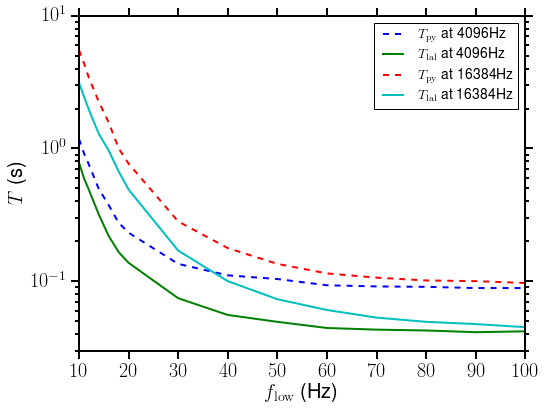

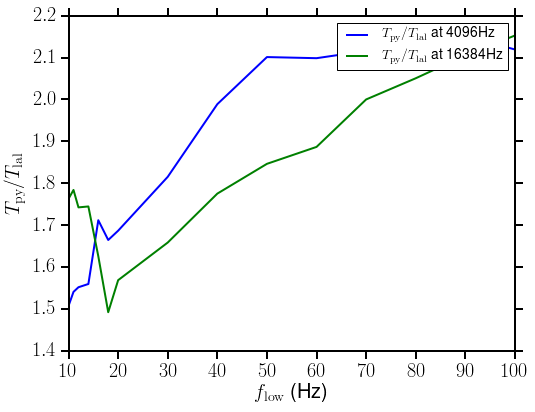

In [49]:
fig = plt.figure(figsize=(8, 6))
axes = fig.add_subplot(111)

axes.plot(f_lowers, ROMpy4k[:, 0], lw=2, ls='--', label=r'$T_{\rm py}$ at 4096Hz')
#axes.fill_between(f_lowers, ROMpy4k[:, 0]-ROMpy4k[:, 1], ROMpy4k[:, 0]+ROMpy4k[:, 1], color='b', alpha=0.3)

axes.plot(f_lowers, ROMlal4k[:, 0], lw=2, label=r'$T_{\rm lal}$ at 4096Hz')
#axes.fill_between(f_lowers, ROMlal4k[:, 0]-ROMlal4k[:, 1], ROMlal4k[:, 0]+ROMlal4k[:, 1], color='b', alpha=0.3)

axes.plot(f_lowers, ROMpy16k[:, 0], lw=2, ls='--', label=r'$T_{\rm py}$ at 16384Hz')
#axes.fill_between(f_lowers, ROMpy16k[:, 0]-ROMpy16k[:, 1], ROMpy16k[:, 0]+ROMpy16k[:, 1], color='b', alpha=0.3)

axes.plot(f_lowers, ROMlal16k[:, 0], lw=2, label=r'$T_{\rm lal}$ at 16384Hz')
#axes.fill_between(f_lowers, ROMlal16k[:, 0]-ROMlal16k[:, 1], ROMlal16k[:, 0]+ROMlal16k[:, 1], color='b', alpha=0.3)

axes.set_yscale('log')
axes.set_xlim([10, 100.0])
axes.set_ylim([0.03, 10.0])
axes.set_xlabel(r'$f_{\rm low}$ (Hz)')
axes.set_ylabel(r'$T$ (s)')
axes.legend(loc='upper right')

fig = plt.figure(figsize=(8, 6))
axes = fig.add_subplot(111)
axes.plot(f_lowers, ROMpy4k[:, 0]/ROMlal4k[:, 0], lw=2, label=r'$T_{\rm py}/T_{\rm lal}$ at 4096Hz')
axes.plot(f_lowers, ROMpy16k[:, 0]/ROMlal16k[:, 0], lw=2, label=r'$T_{\rm py}/T_{\rm lal}$ at 16384Hz')
#axes.set_yscale('log')
axes.set_xlim([10, 100.0])
#axes.set_ylim([0.01, 100.0])
axes.set_xlabel(r'$f_{\rm low}$ (Hz)')
axes.set_ylabel(r'$T_{\rm py}/T_{\rm lal}$')
axes.legend(loc='upper right')

In [33]:
fl = 11
fh = 110
df = 5

f_lowers = np.arange(fl, fh, df)

f_sample = 2**14
EOBopt = np.array([calculate_time(f_lower, f_sample, 'SEOBNRv2_opt', neval=4) for f_lower in f_lowers])

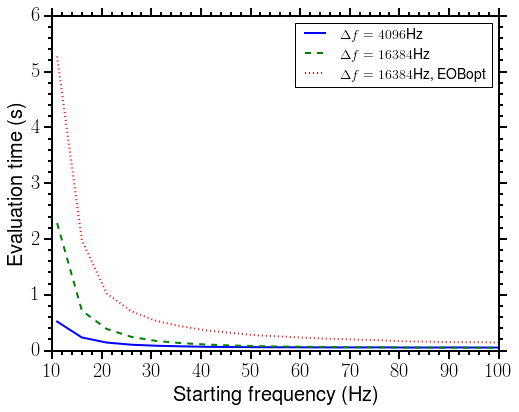

In [34]:
fig = plt.figure(figsize=(8, 6))
axes = fig.add_subplot(111)

axes.plot(f_lowers, ROMlal4k[:, 0], lw=2, label=r'$\Delta f = 4096$Hz')
axes.plot(f_lowers, ROMlal16k[:, 0], lw=2, ls='--', label=r'$\Delta f = 16384$Hz')
axes.plot(f_lowers, EOBopt[:, 0], lw=2, ls=':', label=r'$\Delta f = 16384$Hz, EOBopt')


#axes.set_yscale('log')
axes.set_xlim([10, 100.0])
#axes.set_ylim([0.03, 10.0])
axes.minorticks_on()
axes.set_xlabel(r'Starting frequency (Hz)')
axes.set_ylabel(r'Evaluation time (s)')
axes.legend(loc='upper right')

In [ ]:
f_sample = 2**14
fl = 11
fh = 110
df = 5

ROM = np.array([[f_lower, calculate_time(f_lower, f_sample, 'rom')] for f_lower in np.arange(fl, fh, df)])
EOBopt = np.array([[f_lower, calculate_time(f_lower, f_sample, 'SEOBNRv2_opt')] for f_lower in np.arange(fl, fh, df)])
T1 = np.array([[f_lower, calculate_time(f_lower, f_sample, 'TaylorT1')] for f_lower in np.arange(fl, fh, df)])
T2 = np.array([[f_lower, calculate_time(f_lower, f_sample, 'TaylorT2')] for f_lower in np.arange(fl, fh, df)])
T3 = np.array([[f_lower, calculate_time(f_lower, f_sample, 'TaylorT3')] for f_lower in np.arange(fl, fh, df)])
T4 = np.array([[f_lower, calculate_time(f_lower, f_sample, 'TaylorT4')] for f_lower in np.arange(fl, fh, df)])

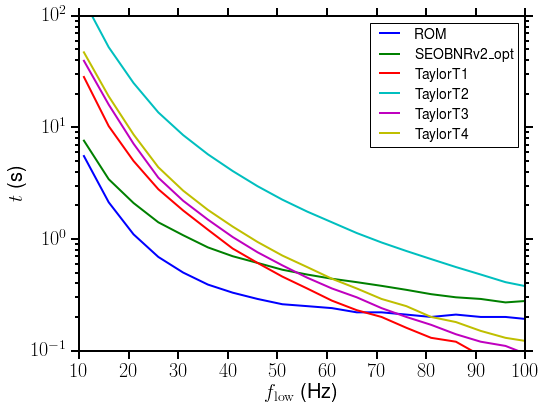

In [15]:
fig = plt.figure(figsize=(8, 6))
axes = fig.add_subplot(111)
axes.plot(ROM[:, 0], ROM[:, 1], lw=2, label='ROM')
axes.plot(EOBopt[:, 0], EOBopt[:, 1], lw=2, label='SEOBNRv2\_opt')
axes.plot(T1[:, 0], T1[:, 1], lw=2, label='TaylorT1')
axes.plot(T2[:, 0], T2[:, 1], lw=2, label='TaylorT2')
axes.plot(T3[:, 0], T3[:, 1], lw=2, label='TaylorT3')
axes.plot(T4[:, 0], T4[:, 1], lw=2, label='TaylorT4')
axes.set_yscale('log')
axes.set_xlim([10, 100.0])
axes.set_ylim([0.1, 100.0])
axes.set_xlabel(r'$f_{\rm low}$ (Hz)')
axes.set_ylabel(r'$t$ (s)')
axes.legend(loc='upper right')

In [27]:
f_sample = 2**14
fl = 11
fh = 115
df = 25
np.arange(fl, fh, df)

array([ 11,  36,  61,  86, 111])

In [45]:
f_sample = 2**14
fl = 11
fh = 115
df = 25

ROM = np.array([[f_lower, calculate_time(f_lower, f_sample, 'rom')] for f_lower in np.arange(fl, fh, df)])
EOBopt = np.array([[f_lower, calculate_time(f_lower, f_sample, 'SEOBNRv2_opt')] for f_lower in np.arange(fl, fh, df)])
T1 = np.array([[f_lower, calculate_time(f_lower, f_sample, 'TaylorT1')] for f_lower in np.arange(fl, fh, df)])
T2 = np.array([[f_lower, calculate_time(f_lower, f_sample, 'TaylorT2')] for f_lower in np.arange(fl, fh, df)])
T3 = np.array([[f_lower, calculate_time(f_lower, f_sample, 'TaylorT3')] for f_lower in np.arange(fl, fh, df)])
T4 = np.array([[f_lower, calculate_time(f_lower, f_sample, 'TaylorT4')] for f_lower in np.arange(fl, fh, df)])

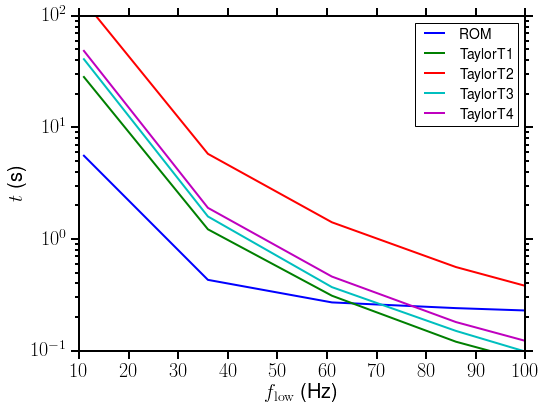

In [49]:
fig = plt.figure(figsize=(8, 6))
axes = fig.add_subplot(111)
axes.plot(ROM[:, 0], ROM[:, 1], lw=2, label='ROM')
#axes.plot(EOBopt[:, 0], EOBopt[:, 1], lw=2, label='SEOBNRv2_opt')
axes.plot(T1[:, 0], T1[:, 1], lw=2, label='TaylorT1')
axes.plot(T2[:, 0], T2[:, 1], lw=2, label='TaylorT2')
axes.plot(T3[:, 0], T3[:, 1], lw=2, label='TaylorT3')
axes.plot(T4[:, 0], T4[:, 1], lw=2, label='TaylorT4')
axes.set_yscale('log')
axes.set_xlim([10, 100.0])
axes.set_ylim([0.1, 100.0])
axes.set_xlabel(r'$f_{\rm low}$ (Hz)')
axes.set_ylabel(r'$t$ (s)')
axes.legend(loc='upper right')

In [22]:
print pycbc.waveform.td_approximants()

['TaylorEt', 'IMRPhenomA', 'IMRPhenomC', 'IMRPhenomB', 'EOBNRv2', 'PhenSpinTaylor', 'PhenSpinTaylorRD', 'NR_hdf5', 'EOBNRv2HM', 'SpinTaylorT4', 'TaylorT1', 'TaylorT3', 'TaylorT2', 'HGimri', 'TaylorT4', 'IMRPhenomD', 'EccentricTD', 'SEOBNRv1', 'SpinDominatedWf', 'SEOBNRv3', 'SEOBNRv2', 'SpinTaylorT1', 'SpinTaylorT2', 'SEOBNRv2_opt']


In [35]:
f_lower = 11.0
f_sample = 2**14
calculate_time(f_lower, f_sample, 'EOBNRv2')

39.52999999999997

In [39]:
f_sample = 2**14
fl = 11
fh = 115
df = 25

EOBNRv2 = np.array([[f_lower, calculate_time(f_lower, f_sample, 'EOBNRv2')] for f_lower in np.arange(fl, fh, df)])
SEOBNRv1 = np.array([[f_lower, calculate_time(f_lower, f_sample, 'SEOBNRv1')] for f_lower in np.arange(fl, fh, df)])
SEOBNRv2 = np.array([[f_lower, calculate_time(f_lower, f_sample, 'SEOBNRv2')] for f_lower in np.arange(fl, fh, df)])
SEOBNRv3 = np.array([[f_lower, calculate_time(f_lower, f_sample, 'SEOBNRv3')] for f_lower in np.arange(fl, fh, df)])

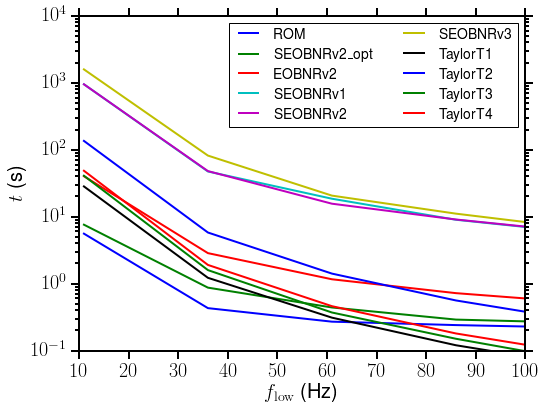

In [48]:
fig = plt.figure(figsize=(8, 6))
axes = fig.add_subplot(111)
axes.plot(ROM[:, 0], ROM[:, 1], lw=2, label='ROM')
axes.plot(EOBopt[:, 0], EOBopt[:, 1], lw=2, label=r'SEOBNRv2\_opt')
axes.plot(EOBNRv2[:, 0], EOBNRv2[:, 1], lw=2, label=r'EOBNRv2')
axes.plot(SEOBNRv1[:, 0], SEOBNRv1[:, 1], lw=2, label=r'SEOBNRv1')
axes.plot(SEOBNRv2[:, 0], SEOBNRv2[:, 1], lw=2, label=r'SEOBNRv2')
axes.plot(SEOBNRv3[:, 0], SEOBNRv3[:, 1], lw=2, label=r'SEOBNRv3')
axes.plot(T1[:, 0], T1[:, 1], lw=2, label='TaylorT1')
axes.plot(T2[:, 0], T2[:, 1], lw=2, label='TaylorT2')
axes.plot(T3[:, 0], T3[:, 1], lw=2, label='TaylorT3')
axes.plot(T4[:, 0], T4[:, 1], lw=2, label='TaylorT4')
axes.set_yscale('log')
axes.set_xlim([10, 100.0])
axes.set_ylim([0.1, 10000])
axes.set_xlabel(r'$f_{\rm low}$ (Hz)')
axes.set_ylabel(r'$t$ (s)')
axes.legend(loc='upper right', ncol=2)